## Analyse the performance curve

In [89]:
import matplotlib.pyplot as plt
import numpy as np
import ipdb

In [102]:
models = ['hred', 'hred-cf', 'when2talk', 'GatedGCN', 'GATRNN']
dataset_name = 'ubuntu'
paths = [f'./processed/{dataset_name}/{i}/conclusion.txt' for i in models]
size = 30

In [1]:
def read_file(path, size=20):
    try:
        with open(path) as f:
            bleu1, bleu2, bleu3, bleu4, rouge, dist1, dist2 = [], [], [], [], [], [], []
            for line in f.readlines():
                line = line.strip()
                if 'BLEU-1' in line:
                    bleu1.append(float(line.replace('BLEU-1: ', '')))
                elif 'BLEU-2' in line:
                    bleu2.append(float(line.replace('BLEU-2: ', '')))
                elif 'BLEU-3' in line:
                    bleu3.append(float(line.replace('BLEU-3: ', '')))
                elif 'BLEU-4' in line:
                    bleu4.append(float(line.replace('BLEU-4: ', '')))
                elif 'ROUGE' in line:
                    rouge.append(float(line.replace('ROUGE: ', '')))
                elif 'Distinct' in line:
                    distinct1, distinct2 = line.split(';')
                    dist1.append(float(distinct1.replace('Distinct-1: ', '').strip()))
                    dist2.append(float(distinct2.replace('Distinct-2: ', '').strip()))

        assert len(bleu1) == size
        assert len(bleu2) == size
        assert len(bleu3) == size
        assert len(bleu4) == size
        assert len(rouge) == size
        assert len(dist1) == size
        assert len(dist2) == size
    except:
        return None
    return (bleu1, bleu2, bleu3, bleu4, rouge, dist1, dist2)

IndentationError: expected an indented block (<ipython-input-1-eff1bcf10f34>, line 30)

In [ ]:
def draw_curve(ax1, ax2, ax3, ax4, ax5, ax6, ax7,
               bleu1, bleu2, bleu3, bleu4, rouge, dist1, dist2, m):
    x = np.arange(1, size + 1)
    
    ax1.plot(x, bleu1, label=m)
    ax1.legend()
    ax1.set_title('BLEU-1')
    
    ax2.plot(x, bleu2, label=m)
    ax2.legend()
    ax2.set_title('BLEU-2')
    
    ax3.plot(x, bleu3, label=m)
    ax3.legend()
    ax3.set_title('BLEU-3')
    
    ax4.plot(x, bleu4, label=m)
    ax4.legend()
    ax4.set_title('BLEU-4')
    
    ax5.plot(x, rouge, label=m)
    ax5.legend()
    ax5.set_title('ROUGE')
    
    ax6.plot(x, dist1, label=m)
    ax6.legend()
    ax6.set_title('Distinct-1')
    
    ax7.plot(x, dist2, label=m)
    ax7.legend()
    ax7.set_title('Distinct-2')

In [105]:
def meta_data(bar, data):
    try:
        print(f'{bar}: Max data {np.max(data)}, epoch: {1 + np.argmax(data)}')
    except:
        return 

In [106]:
dataset = []
for m, path in zip(models, paths):
    print(f'========== {m} : {path} ==========')
    data = read_file(path, size=size)
    if data:
        dataset.append(data)
        meta_data('BLEU-1', data[0])
        meta_data('BLEU-2', data[0])
        meta_data('BLEU-3', data[0])
        meta_data('BLEU-4', data[0])
        meta_data('ROUGE', data[0])
        meta_data('Dist-1', data[1])
        meta_data('Dist-2', data[2])

========== ./processed/dailydialog/HRED/conclusion.txt ==========
BLEU-1: Max data 0.1759, epoch: 20
BLEU-2: Max data 0.1192, epoch: 20
BLEU-3: Max data 0.1047, epoch: 20
BLEU-4: Max data 0.0977, epoch: 18
ROUGE: Max data 0.0353, epoch: 20
Dist-1: Max data 0.0227, epoch: 20
Dist-2: Max data 0.114, epoch: 20
========== ./processed/dailydialog/GatedGCN/conclusion.txt ==========
BLEU-1: Max data 0.1713, epoch: 13
BLEU-2: Max data 0.1143, epoch: 13
BLEU-3: Max data 0.1002, epoch: 13
BLEU-4: Max data 0.094, epoch: 13
ROUGE: Max data 0.029, epoch: 18
Dist-1: Max data 0.0266, epoch: 20
Dist-2: Max data 0.1678, epoch: 20


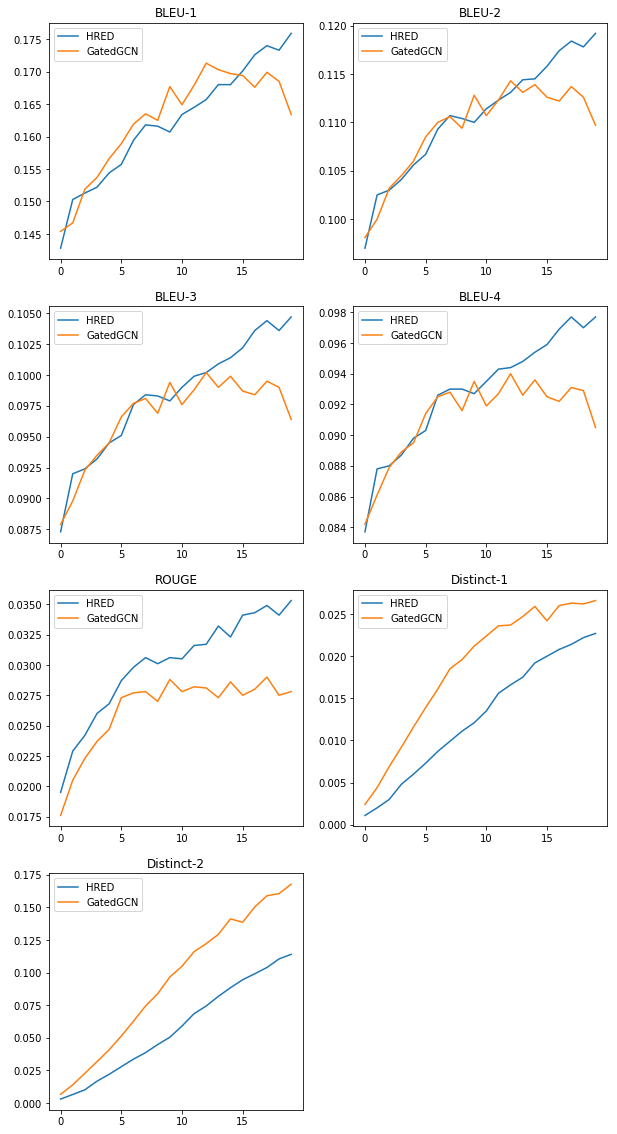

In [107]:
plt.figure(figsize=(10, 20))
sub = [plt.subplot(4, 2, 1), plt.subplot(4, 2, 2), plt.subplot(4, 2, 3),
       plt.subplot(4, 2, 4), plt.subplot(4, 2, 5), plt.subplot(4, 2, 6),
       plt.subplot(4, 2, 7)]

for d, m in zip(dataset, models):
    draw_curve(*sub, *d, m)
    
plt.savefig(f'./img/{dataset_name}.png')